# MODELO 5 - CGAN para generar una imagen del CIFAR-10 a pedido del usuario

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.13.0


- Importo las librerias neceasarias

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Embedding, Concatenate
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [5]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

0


- Cargo el dataset

In [6]:
tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]

print(img_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

32
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

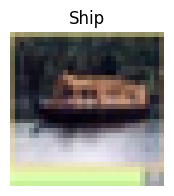

In [7]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

# Construcción del generador

In [8]:
def build_generator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label) # Capa de embedding para las etiquetas
    img_size_in = img_size // 4
    n_nodes = img_size_in * img_size_in
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa para las etiquetas
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa

    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido
    n_nodes = 512 * img_size_in * img_size_in
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa para el ruido
    gen = Reshape((img_size_in, img_size_in, 512), name='Generator_Reshape')(gen) # Cambio la forma de la capa
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li]) # Concateno las capas
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 16x16x512
    gen = BatchNormalization(momentum=0.8, name='Generator_BatchNormalization_1')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_1')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 32x32x256
    gen = BatchNormalization(momentum=0.8, name='Generator_BatchNormalization_2')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', name='Conv2DTranspose_3')(gen)  # 32x32x128
    gen = BatchNormalization(momentum=0.8, name='Generator_BatchNormalization_3')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_3')(gen)
    #---------------------------------------------------------------------------------#
    out_layer = Conv2DTranspose(3, (5, 5), strides=(1,1), activation='tanh', padding='same', name='Output_Conv2DTranspose_4')(gen)  # 32x32x3
    #---------------------------------------------------------------------------------#

    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='/content/drive/MyDrive/Lembo/generator_structure_m5_cifar10.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [9]:
def build_discriminator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    n_nodes = img_size * img_size
    li = Dense(n_nodes, name='Label_Dense')(li)
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li)

    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input')
    #in_image = Dropout(0.75, name='Dropout')(in_image)
    merge = Concatenate(name='Concatenate')([in_image, li])
    #---------------------------------------------------------------------------------#
    fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='Conv2D_1')(merge) # 16x16x32
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='Conv2D_2')(fe) # 8x8x64
    fe = BatchNormalization(momentum=0.8,name='Generator_BatchNormalization_1')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2D_3')(fe) # 4x4x128
    fe = BatchNormalization(momentum=0.8,name='Generator_BatchNormalization_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(256, (5, 5), strides=(2, 2), padding='same', name='Conv2D_4')(fe) # 4x4x256
    fe = BatchNormalization(momentum=0.8, name='Generator_BatchNormalization_3')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_4')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(512, (5, 5), strides=(2, 2), padding='same', name='Conv2D_5')(fe) # 2x2x512
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe)
    fe = Dropout(0.4, name='Dropout')(fe)
    out_layer = Dense(1, activation='sigmoid', name='Output_Dense')(fe)
    #---------------------------------------------------------------------------------#

    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='/content/drive/MyDrive/Lembo/discriminator_structure_m5_cifar10.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [10]:
def show_samples(num_samples, noise_dim, g_model, epoch):

  fig, axes = plt.subplots(10, num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("/content/drive/MyDrive/Lembo/evolution_m5_cifar10", exist_ok=True)
  plt.savefig(f"/content/drive/MyDrive/Lembo/evolution_m5_cifar10/images_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [11]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [12]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [13]:
epoch_count = 20 # Cantidad de epocas
batch_size = 50 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 # Learning rate
n_class = len(tags)  # numero de clases

- Construyo el generador

In [14]:
g_optimizer =  RMSprop(learning_rate=lr) #Adam(learning_rate=lr, beta_1=0.5)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Latent_Input (InputLayer)   [(None, 100)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                                  
 Generator_Dense (Dense)     (None, 32768)                3309568   ['Latent_Input[0][0]']        
                                                                                          

- Construyo el discriminador

In [15]:
d_optimizer = RMSprop(learning_rate=lr) #Adam(learning_rate=lr, beta_1=0.5)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                                  
 Label_Dense (Dense)         (None, 1, 1024)              52224     ['Embedding[0][0]']           
                                                                                                  
 Image_Input (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                      

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [15]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = g_model([noise, real_labels], training = True) #  Genero imagenes falsas
            pred_real = d_model([real_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes reales
            pred_fake = d_model([generated_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes falsas
           
            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
            g_loss = generator_loss(pred_fake) # Calculo la loss del generador

        grads_g = gen_tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        grads_d = disc_tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes

        g_optimizer.apply_gradients(zip(grads_g, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador
        d_optimizer.apply_gradients(zip(grads_d, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [16]:
@tf.function # Compiles the test_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([noise, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales

        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        g_loss = generator_loss(pred_fake) # Calculo la loss del generador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [17]:
def train(train_dataset, test_dataset, epoch_count, batch_size):

    num_train_batches = len(train_dataset)
    num_test_batches = len(test_dataset)

    d_loss_list_epoch_train = np.zeros(epoch_count)
    g_loss_list_epoch_train = np.zeros(epoch_count)
    d_loss_list_epoch_test = np.zeros(epoch_count)
    g_loss_list_epoch_test = np.zeros(epoch_count)
    precision_list_epoch_train = np.zeros(epoch_count)
    recall_list_epoch_train = np.zeros(epoch_count)
    f1_list_epoch_train = np.zeros(epoch_count)
    accuracy_list_epoch_train = np.zeros(epoch_count)
    precision_list_epoch_test = np.zeros(epoch_count)
    recall_list_epoch_test = np.zeros(epoch_count)
    f1_list_epoch_test = np.zeros(epoch_count)
    accuracy_list_epoch_test = np.zeros(epoch_count)
    d_loss_list_itern_train = np.zeros(epoch_count *num_train_batches)
    g_loss_list_itern_train = np.zeros(epoch_count * num_train_batches)
    d_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)
    g_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)

    itern_train_counter = 0
    itern_test_counter = 0

    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)

        d_loss_list_batch_train_aux = np.zeros(num_train_batches)
        g_loss_list_batch_train_aux = np.zeros(num_train_batches)
        d_loss_list_batch_test_aux = np.zeros(num_test_batches)
        g_loss_list_batch_test_aux = np.zeros(num_test_batches)
        precision_list_batch_train = np.zeros(num_train_batches)
        recall_list_batch_train = np.zeros(num_train_batches)
        f1_list_batch_train = np.zeros(num_train_batches)
        accuracy_list_batch_train = np.zeros(num_train_batches)
        precision_list_batch_test = np.zeros(num_test_batches)
        recall_list_batch_test = np.zeros(num_test_batches)
        f1_list_batch_test = np.zeros(num_test_batches)
        accuracy_list_batch_test = np.zeros(num_test_batches)

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches para el conjunto de entrenamiento

            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train_aux[itern] = d_loss_train
            g_loss_list_batch_train_aux[itern] = g_loss_train
            d_loss_list_itern_train[itern_train_counter] = d_loss_train
            g_loss_list_itern_train[itern_train_counter] = g_loss_train
            itern_train_counter += 1

            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,)) # Reshapeo para que all_pred_labels_train (tiene la dimensión de la salida del discriminador) tenga la misma forma que all_real_labels_train

            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train[itern] = precision_train
            recall_list_batch_train[itern] = recall_train
            f1_list_batch_train[itern] = f1_train
            accuracy_list_batch_train[itern] = accuracy_train
            itern=itern+1

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches para el conjunto de testeo

            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_test_aux[itern] = d_loss_test
            g_loss_list_batch_test_aux[itern] = g_loss_test
            d_loss_list_itern_test[itern_test_counter] = d_loss_test
            g_loss_list_itern_test[itern_test_counter] = g_loss_test
            itern_test_counter += 1

            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test[itern] = precision_test
            recall_list_batch_test[itern] = recall_test
            f1_list_batch_test[itern] = f1_test
            accuracy_list_batch_test[itern] = accuracy_test

            itern=itern+1

        d_loss_list_epoch_train[epoch] = np.mean(d_loss_list_batch_train_aux)
        g_loss_list_epoch_train[epoch] = np.mean(g_loss_list_batch_train_aux)
        d_loss_list_epoch_test[epoch] = np.mean(d_loss_list_batch_test_aux)
        g_loss_list_epoch_test[epoch] = np.mean(g_loss_list_batch_test_aux)
        precision_list_epoch_train[epoch] = np.mean(precision_list_batch_train)
        recall_list_epoch_train[epoch] = np.mean(recall_list_batch_train)
        f1_list_epoch_train[epoch] = np.mean(f1_list_batch_train)
        accuracy_list_epoch_train[epoch] = np.mean(accuracy_list_batch_train)
        precision_list_epoch_test[epoch] = np.mean(precision_list_batch_test)
        recall_list_epoch_test[epoch] = np.mean(recall_list_batch_test)
        f1_list_epoch_test[epoch] = np.mean(f1_list_batch_test)
        accuracy_list_epoch_test[epoch] = np.mean(accuracy_list_batch_test)

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_train_aux)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_test_aux)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 2 == 0:
            show_samples(4, noise_dim, g_model, epoch)
        if epoch % 2 == 0:
            g_model.save(f"/content/drive/MyDrive/Lembo/gmodel_m5_cifar10_{epoch}.h5")
            d_model.save(f"/content/drive/MyDrive/Lembo/dmodel_m5_cifar10_{epoch}.h5")
            epochs = np.arange(1, epoch_count+1)
            np.savez(f"/content/drive/MyDrive/Lembo/metricas_m5_cifar10_{epoch}.npz", epochs= epochs, d_loss_itern_train=d_loss_list_itern_train, g_loss_list_itern_train=g_loss_list_itern_train, d_loss_list_itern_test=d_loss_list_itern_test, g_loss_list_itern_test=g_loss_list_itern_test, d_loss_list_epoch_train=d_loss_list_epoch_train, g_loss_list_epoch_train=g_loss_list_epoch_train, d_loss_list_epoch_test=d_loss_list_epoch_test, g_loss_list_epoch_test=g_loss_list_epoch_test, precision_list_epoch_train=precision_list_epoch_train, recall_list_epoch_train=recall_list_epoch_train, f1_list_epoch_train=f1_list_epoch_train, accuracy_list_epoch_train=accuracy_list_epoch_train, precision_list_epoch_test=precision_list_epoch_test, recall_list_epoch_test=recall_list_epoch_test, f1_list_epoch_test=f1_list_epoch_test, accuracy_list_epoch_test=accuracy_list_epoch_test)

    return d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 64

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 64

d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test = train(train_dataset, test_dataset, epoch_count, batch_size)
epochs = np.arange(1, epoch_count+1)

np.savez("/content/drive/MyDrive/Lembo/metricas_m5_cifar10.npz", epochs= epochs, d_loss_itern_train=d_loss_list_itern_train, g_loss_list_itern_train=g_loss_list_itern_train, d_loss_list_itern_test=d_loss_list_itern_test, g_loss_list_itern_test=g_loss_list_itern_test, d_loss_list_epoch_train=d_loss_list_epoch_train, g_loss_list_epoch_train=g_loss_list_epoch_train, d_loss_list_epoch_test=d_loss_list_epoch_test, g_loss_list_epoch_test=g_loss_list_epoch_test, precision_list_epoch_train=precision_list_epoch_train, recall_list_epoch_train=recall_list_epoch_train, f1_list_epoch_train=f1_list_epoch_train, accuracy_list_epoch_train=accuracy_list_epoch_train, precision_list_epoch_test=precision_list_epoch_test, recall_list_epoch_test=recall_list_epoch_test, f1_list_epoch_test=f1_list_epoch_test, accuracy_list_epoch_test=accuracy_list_epoch_test)
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m5_cifar10.keras")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m5_cifar10.keras")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m5_cifar10.h5")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m5_cifar10.h5")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m5_cifar10.tf")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m5_cifar10.tf")

Epoch:  1


Test - batch/batches: 100%|██████████| 200/200 [00:14<00:00, 13.41it/s]


Train - Época: 1 -- Generator Loss: 0.9474636520199711, Discriminator Loss: 1.3985330217927694
Test - Época: 1 -- Generator Loss: 0.7269847917556763, Discriminator Loss: 1.2749174350500108

Tomó 277.6382966041565 segundos. 


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  2


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.59it/s]


Train - Época: 2 -- Generator Loss: 1.029464014992118, Discriminator Loss: 1.2430932809114457
Test - Época: 2 -- Generator Loss: 0.8186391815543175, Discriminator Loss: 1.274224255681038

Tomó 275.62858748435974 segundos. 


Epoch:  3


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.61it/s]


Train - Época: 3 -- Generator Loss: 1.046020721167326, Discriminator Loss: 1.1989296934604645
Test - Época: 3 -- Generator Loss: 1.2066125267744063, Discriminator Loss: 1.2495486479997635

Tomó 244.90191459655762 segundos. 


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  4


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 4 -- Generator Loss: 1.2751863663420082, Discriminator Loss: 1.097296611815691
Test - Época: 4 -- Generator Loss: 1.5339999449253083, Discriminator Loss: 1.3141086012125016

Tomó 250.8778178691864 segundos. 


Epoch:  5


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.51it/s]


Train - Época: 5 -- Generator Loss: 1.3847149131000043, Discriminator Loss: 1.0541830398738383
Test - Época: 5 -- Generator Loss: 1.55008549451828, Discriminator Loss: 1.2774002158641815

Tomó 244.70279669761658 segundos. 


1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  6


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 6 -- Generator Loss: 1.464150942966342, Discriminator Loss: 1.0284699803292752
Test - Época: 6 -- Generator Loss: 1.131676907837391, Discriminator Loss: 1.2481083250045777

Tomó 282.3835201263428 segundos. 


Epoch:  7


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.58it/s]


Train - Época: 7 -- Generator Loss: 1.4872626768648625, Discriminator Loss: 1.0133359859883786
Test - Época: 7 -- Generator Loss: 1.0915208393335343, Discriminator Loss: 1.2378297698497773

Tomó 275.63374280929565 segundos. 


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  8


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 8 -- Generator Loss: 1.5012839565128089, Discriminator Loss: 1.0150049093961715
Test - Época: 8 -- Generator Loss: 0.9261472901701927, Discriminator Loss: 1.2319671320915222

Tomó 251.07229018211365 segundos. 


Epoch:  9


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 9 -- Generator Loss: 1.5151630813777446, Discriminator Loss: 1.010085191398859
Test - Época: 9 -- Generator Loss: 0.8871771615743637, Discriminator Loss: 1.220452356338501

Tomó 282.3791353702545 segundos. 


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  10


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 10 -- Generator Loss: 1.5717557525485755, Discriminator Loss: 0.9833525582104922
Test - Época: 10 -- Generator Loss: 1.0381358954310418, Discriminator Loss: 1.2014117348194122

Tomó 282.38244009017944 segundos. 


Epoch:  11


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 11 -- Generator Loss: 1.5681410648450256, Discriminator Loss: 0.9925006279349327
Test - Época: 11 -- Generator Loss: 1.4016652655601503, Discriminator Loss: 1.3009524154663086

Tomó 251.27925395965576 segundos. 


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  12


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.57it/s]


Train - Época: 12 -- Generator Loss: 1.5005711815655232, Discriminator Loss: 1.012253756225109
Test - Época: 12 -- Generator Loss: 1.2815936625003814, Discriminator Loss: 1.2586615258455276

Tomó 244.41555500030518 segundos. 


Epoch:  13


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 13 -- Generator Loss: 1.5723147853463888, Discriminator Loss: 0.9865163584202528
Test - Época: 13 -- Generator Loss: 0.8207515421509742, Discriminator Loss: 1.2424358004331588

Tomó 282.38246417045593 segundos. 


1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  14


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


Train - Época: 14 -- Generator Loss: 1.5821712137907744, Discriminator Loss: 0.9781303758323192
Test - Época: 14 -- Generator Loss: 1.1415006029605865, Discriminator Loss: 1.2449832141399384

Tomó 244.41938829421997 segundos. 


Epoch:  15


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.60it/s]


Train - Época: 15 -- Generator Loss: 1.6218644233494997, Discriminator Loss: 0.9665145641863346
Test - Época: 15 -- Generator Loss: 1.1160125029087067, Discriminator Loss: 1.2865636211633682

Tomó 275.6177456378937 segundos. 


1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  16


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


Train - Época: 16 -- Generator Loss: 1.5795144995599986, Discriminator Loss: 0.9759781491309404
Test - Época: 16 -- Generator Loss: 1.1767974054813386, Discriminator Loss: 1.2413258862495422

Tomó 275.6042823791504 segundos. 


Epoch:  17


Test - batch/batches: 100%|██████████| 200/200 [00:13<00:00, 14.67it/s]


Train - Época: 17 -- Generator Loss: 1.6533489504158496, Discriminator Loss: 0.9585025053620339
Test - Época: 17 -- Generator Loss: 0.8253102877736092, Discriminator Loss: 1.3157351207733154

Tomó 244.31928539276123 segundos. 


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  18


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 18 -- Generator Loss: 1.6381032789945602, Discriminator Loss: 0.9571048333346843
Test - Época: 18 -- Generator Loss: 1.3651235967874527, Discriminator Loss: 1.3306805849075318

Tomó 282.39706015586853 segundos. 


Epoch:  19


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 19 -- Generator Loss: 1.6766938190609217, Discriminator Loss: 0.9445314567983151
Test - Época: 19 -- Generator Loss: 0.9895890003442764, Discriminator Loss: 1.344966423511505

Tomó 251.3394546508789 segundos. 


1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch:  20


Test - batch/batches: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]


Train - Época: 20 -- Generator Loss: 1.7201965946108102, Discriminator Loss: 0.9281709752827882
Test - Época: 20 -- Generator Loss: 0.9884313195943832, Discriminator Loss: 1.3356172490119933

Tomó 282.38150548934937 segundos. 




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Graficas de la pérdida para el generador y el discriminador en función del número de iteraciones

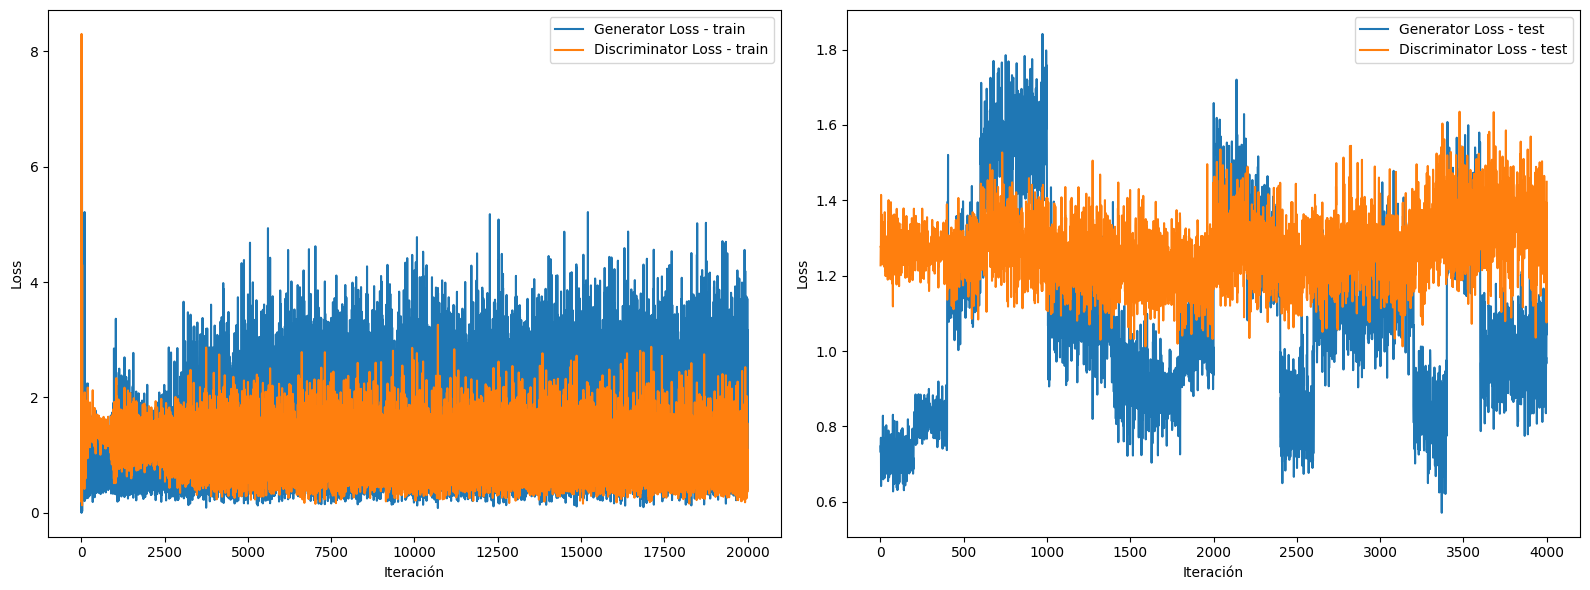

In [14]:
data = np.load("metricas_m5_cifar10.npz")

iteration_train = np.arange(1, len(X_train)/batch_size*epoch_count+1)
iteration_test = np.arange(1, len(X_test)/batch_size*epoch_count+1)
d_loss_itern_train = data['d_loss_itern_train']
g_loss_itern_train = data['g_loss_list_itern_train']
d_loss_itern_test = data['d_loss_list_itern_test']
g_loss_itern_test = data['g_loss_list_itern_test']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(iteration_train, g_loss_itern_train, label='Generator Loss - train')
axs[0].plot(iteration_train, d_loss_itern_train, label='Discriminator Loss - train')
axs[0].set_xlabel('Iteración')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(iteration_test, g_loss_itern_test, label='Generator Loss - test')
axs[1].plot(iteration_test, d_loss_itern_test, label='Discriminator Loss - test')
axs[1].set_xlabel('Iteración')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

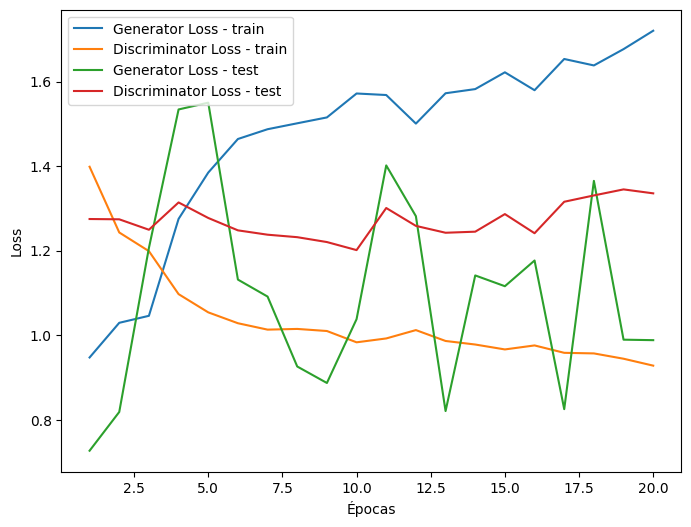

In [16]:
data = np.load("metricas_m5_cifar10.npz")

epochs = data['epochs']
d_loss_train = data['d_loss_list_epoch_train']
g_loss_train = data['g_loss_list_epoch_train']
d_loss_test = data['d_loss_list_epoch_test']
g_loss_test = data['g_loss_list_epoch_test']

plt.figure(figsize=(8,6))
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficas de las métricas para el discriminador en función del número de épocas

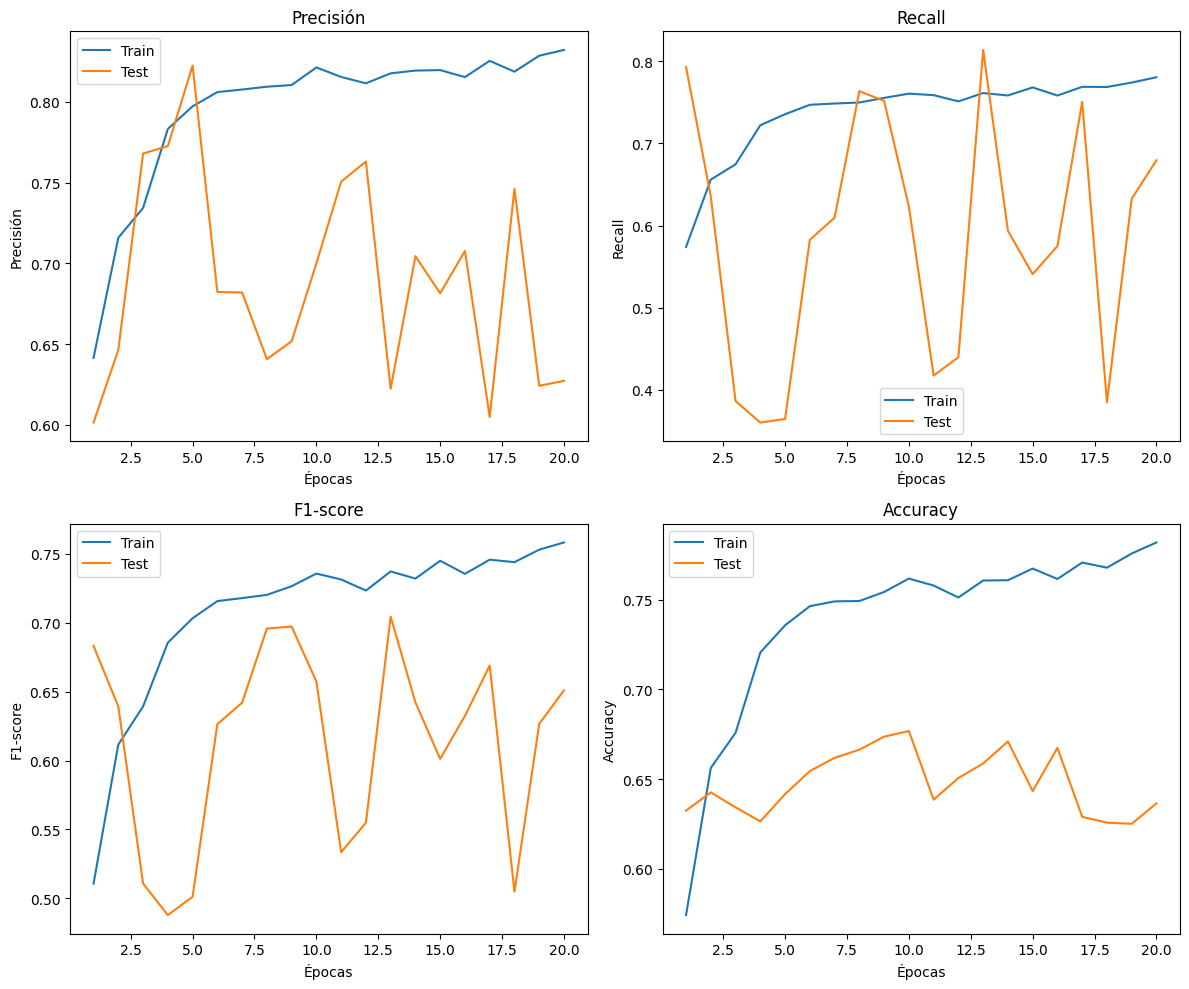

In [18]:
data = np.load("metricas_m5_cifar10.npz")
epochs = data['epochs']
precision_train = data['precision_list_epoch_train']
recall_train = data['recall_list_epoch_train']
f1_train = data['f1_list_epoch_train']
accuracy_train = data['accuracy_list_epoch_train']
precision_test = data['precision_list_epoch_test']
recall_test = data['recall_list_epoch_test']
f1_test = data['f1_list_epoch_test']
accuracy_test = data['accuracy_list_epoch_test']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')
plt.tight_layout()
plt.show()

# Generación de una imagen del cifar 100 pedida por el usuario

Tamaño imagen generada:  (1, 32, 32, 3)


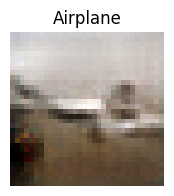

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image

noise_dim = 100 # Dimension del ruido

tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def get_index(word, tags_list):
    try:
        return tags_list.index(word)
    except ValueError:
        return -1  # Devuelve -1 si la palabra no se encuentra en la lista

# Cargar el modelo generador
g_model = load_model('gmodel_m5_cifar10.h5')

imagen_a_generar = 'Airplane'
index = get_index(imagen_a_generar, tags)

#label = tf.expand_dims(numero_a_generar, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10
label = tf.ones(1)*index

# Generar ruido aleatorio
noise = tf.random.normal(shape=(1, noise_dim))

# Generar imagen falsa
generated_image = g_model([noise, label]) #  Genero imagenes falsas
#generated_image = g_model.predict([noise, label])
print("Tamaño imagen generada: ", generated_image.shape)

plt.figure(figsize=(2,2))
img = image.array_to_img(generated_image[0], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"{tags[index]}")
plt.show()